In [1]:
import requests

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time
import datetime

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from scipy.stats import bernoulli

import numpy as np
from scipy import stats

# Introduction

Our project will address two research questions: 

1) What is the causal impact of Ozone level on the age-adjusted prevalence of asthma? 

2) Given the selected features, build a model that can predict the age-adjusted prevalence of Asthma.

We will mainly be using three datasets: 

1) Annual State-Level U.S. Chronic Disease Indicators filtered for asthma 

2) Modified PM2.5 dataset 

3) Modified ozone dataset 

(We computed the daily mean PM2.5 and ozone level for each state due to the large size of the two datasets)

In [2]:
asthma = pd.read_csv('Asthma.csv')
asthma.head(5)

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning:

Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.



,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2012,2012,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,1,AST,AST4_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
1,2014,2014,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,1,AST,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
2,2011,2011,AZ,Arizona,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,4,AST,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
3,2015,2015,CT,Connecticut,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,9,AST,AST4_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2011,2011,FL,Florida,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,...,12,AST,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN


In [3]:
pm25 = pd.read_csv('PM25.csv').drop('Unnamed: 0', axis = 1)
pm25.head(5)

,statefip,01JAN2011,02JAN2011,03JAN2011,04JAN2011,05JAN2011,06JAN2011,07JAN2011,08JAN2011,09JAN2011,...,22DEC2014,23DEC2014,24DEC2014,25DEC2014,26DEC2014,27DEC2014,28DEC2014,29DEC2014,30DEC2014,31DEC2014
0,1,5.196290,4.984104,7.209600,14.935756,13.690596,8.585039,5.775294,5.281323,5.653868,...,6.277790,4.574800,4.386800,6.835787,10.125804,8.777215,5.365212,6.648250,8.164014,10.379025
1,4,8.827295,7.360635,12.533566,11.775343,10.416504,10.179782,13.626992,9.685872,11.871241,...,15.854941,9.668950,9.149272,8.300927,7.769705,12.176465,11.554488,14.450957,10.587868,9.241211
2,5,5.786716,7.738383,8.606869,11.491568,12.038085,8.903985,5.570338,4.409569,5.063505,...,9.685457,5.797382,5.141571,4.235675,7.013927,5.985645,6.463000,8.268514,10.546440,9.648933
3,6,13.559603,8.105638,7.545573,9.488456,10.519056,12.612504,19.867717,16.772288,14.125612,...,11.942154,7.795916,8.594198,5.446916,5.797357,11.192144,14.167456,14.964028,10.647488,11.708086
4,8,3.949587,5.036296,8.523260,14.477241,4.653650,7.191430,7.362693,14.661273,7.734357,...,3.371333,4.931956,6.957509,3.884519,5.561388,8.712206,13.681786,10.666739,7.372589,13.418500


In [4]:
ozone = pd.read_csv('ozone.csv').drop('Unnamed: 0', axis = 1)
ozone.head(5)

,statefip,01JAN2011,02JAN2011,03JAN2011,04JAN2011,05JAN2011,06JAN2011,07JAN2011,08JAN2011,09JAN2011,...,22DEC2014,23DEC2014,24DEC2014,25DEC2014,26DEC2014,27DEC2014,28DEC2014,29DEC2014,30DEC2014,31DEC2014
0,1,32.721949,34.568758,30.375864,34.251780,25.669446,35.428277,42.567707,37.360915,29.332703,...,18.379176,26.374789,27.970030,24.502318,29.265682,26.539294,21.010491,13.935375,20.869850,20.861829
1,4,37.600710,36.208419,28.965546,22.845798,24.252316,21.691751,27.932608,32.126367,38.859366,...,30.941900,41.052629,35.428706,35.638700,33.114273,29.577865,30.148626,30.046606,31.062371,30.077946
2,5,30.239673,34.037387,34.557988,31.986139,33.764155,39.655212,35.805370,34.693654,27.113124,...,18.632721,26.653000,16.930287,33.680957,24.719975,19.922840,15.101408,20.903627,25.459039,23.421275
3,6,32.563569,28.175180,23.692732,24.940009,20.267972,19.010336,16.436324,22.489915,28.328533,...,19.186271,19.241213,30.206364,36.871303,32.910782,30.952254,29.631145,29.022493,33.305325,32.842572
4,8,37.797404,36.801446,36.713041,41.866961,42.656211,38.958352,33.559118,23.684557,37.000746,...,35.381818,39.690000,28.191967,33.211362,29.620425,31.601164,28.668236,28.348465,26.475895,29.747821


# Data Cleaning

For data cleaning, we first loaded individual datasets and dropped those containing N/A values. We selected columns relevant to our reasearch question, and merged all 3 datasets into one on Year and StateID.\
Since we dropped various rows containing N/A values, the data used to generate models as well as make predictions may not be as accurate. 

### 1) Asthma Dataset

In [5]:
asthma['Question'].value_counts()

Asthma mortality rate                                                                      9816
Current asthma prevalence among adults aged >= 18 years                                    7830
Influenza vaccination among noninstitutionalized adults aged 18-64 years with asthma       7830
Influenza vaccination among noninstitutionalized adults aged >= 65 years with asthma       7830
Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with asthma    7830
Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with asthma    7830
Hospitalizations for asthma                                                                6516
Emergency department visit rate for asthma                                                 6312
Asthma prevalence among women aged 18-44 years                                             2925
Name: Question, dtype: int64

Among the 9 questions addressed in the asthma dataset, we will only explore **age-adjusted** 'current asthma prevalence among adults aged >= 18 years' for our project. And we will only use data that are between 2011-2014 to match the time frame in PM2.5 and ozone datasets.

#### Current asthma prevalence among adults aged >= 18 years (age-adjusted rate)

In [6]:
prevalence = asthma[asthma['Question'] == 'Current asthma prevalence among adults aged >= 18 years']
# Select data from 2011-2014
prevalence = prevalence[(prevalence['YearStart'] >= 2011) & (prevalence['YearEnd'] <= 2014) & (prevalence['DataValueTypeID'] == 'AGEADJPREV')]
selected_columns = ['YearStart', 'LocationDesc', 'LocationID', 'DataValue', 'StratificationCategoryID1', 'StratificationID1']
prevalence_selected = prevalence[selected_columns]
prevalence_selected = prevalence_selected. rename(columns={'YearStart':'Year','LocationDesc':'State', 'LocationID': 'StateID',
                                                'DataValue':'Prevalence', 'StratificationCategoryID1':'StratificationCategory',
                                                'StratificationID1':'Stratification'})
# Drop NA rows
prevalence_cleaned = prevalence_selected.dropna()
prevalence_cleaned.head(5)

,Year,State,StateID,Prevalence,StratificationCategory,Stratification
22699,2013,Utah,49,7.2,GENDER,GENM
22721,2014,Alabama,1,9.5,RACE,WHT
22728,2014,Colorado,8,9.1,RACE,OTH
22729,2011,Colorado,8,15.5,RACE,MRC
22730,2011,Arkansas,5,25.5,RACE,MRC


### 2) PM2.5 & Ozone

In [7]:
pm25_cleaned = pm25.melt(id_vars='statefip')
pm25_cleaned = pm25_cleaned.rename(columns={'statefip':'StateID','variable':'Date', 'value': 'PM2.5'})
# Add a year column
pm25_cleaned['Year'] = pm25_cleaned['Date'].str[-4:]
# Group PM2.5 by year and take the mean
pm25_grouped = pm25_cleaned.groupby(["Year", "StateID"]).mean().reset_index()
pm25_grouped.head(5)

,Year,StateID,PM2.5
0,2011,1,10.722394
1,2011,4,7.957158
2,2011,5,10.607418
3,2011,6,10.424960
4,2011,8,6.438329


In [8]:
ozone_cleaned = ozone.melt(id_vars='statefip')
ozone_cleaned = ozone_cleaned.rename(columns={'statefip':'StateID','variable':'Date', 'value': 'Ozone'})
# Add a year column
ozone_cleaned['Year'] = ozone_cleaned['Date'].str[-4:]
# Group ozone level by year and take the mean
ozone_grouped = ozone_cleaned.groupby(["Year", "StateID"]).mean().reset_index()
ozone_grouped.head(5)

,Year,StateID,Ozone
0,2011,1,41.170865
1,2011,4,46.998399
2,2011,5,41.012629
3,2011,6,39.981360
4,2011,8,47.043940


In [9]:
# Merge pm25_grouped with ozone_grouped
pm25_ozone = pd.merge(pm25_grouped, ozone_grouped, how='left', on=['Year','StateID'])
pm25_ozone.head(5)

,Year,StateID,PM2.5,Ozone
0,2011,1,10.722394,41.170865
1,2011,4,7.957158,46.998399
2,2011,5,10.607418,41.012629
3,2011,6,10.424960,39.981360
4,2011,8,6.438329,47.043940


### 3) Merge asthma, PM2.5 and ozone datasets together

In [10]:
# Convert 'Year' column in pm25_ozone to float
pm25_ozone['Year'] = pm25_ozone['Year'].apply(lambda x: float(x))

In [11]:
prevalence_airquality = pd.merge(prevalence_cleaned, pm25_ozone, how='left', on=['Year','StateID'])
# Drop NA rows
prevalence_final = prevalence_airquality.dropna()
prevalence_final.head(5)

,Year,State,StateID,Prevalence,StratificationCategory,Stratification,PM2.5,Ozone
0,2013,Utah,49,7.2,GENDER,GENM,9.311432,41.073701
1,2014,Alabama,1,9.5,RACE,WHT,11.025839,37.455517
2,2014,Colorado,8,9.1,RACE,OTH,6.737662,44.177632
3,2011,Colorado,8,15.5,RACE,MRC,6.438329,47.043940
4,2011,Arkansas,5,25.5,RACE,MRC,10.607418,41.012629


# EDA

1) Asthma: Gender

Text(0.5, 1.0, 'Prevalence VS Gender')

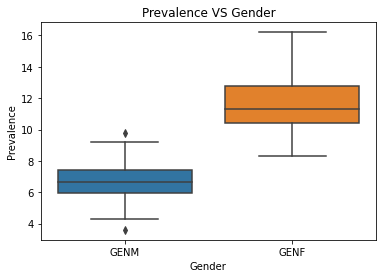

In [12]:
prevalence_gender = prevalence_final[prevalence_final['StratificationCategory'] == 'GENDER']
sns.boxplot(x = 'Stratification', y = 'Prevalence', data = prevalence_gender)
plt.xlabel('Gender')
plt.title('Prevalence VS Gender')

From boxplots generated between mortality and prevalence vs gender, We observed female having both higher mortality rate and prevalence for asthma. We suspect a correlation between gender and asthma prevalence where female are more susceptible to the disease.

Text(0.5, 1.0, 'Mortality rate for each year')

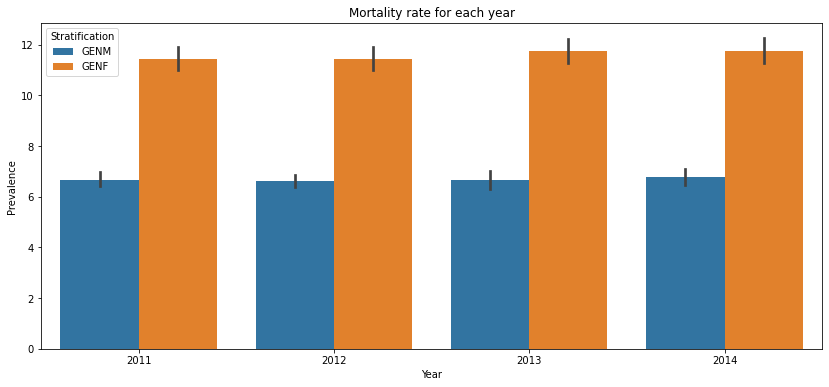

In [13]:
plt.figure(figsize = (14, 6))
prevalence_gender = prevalence_final[prevalence_final['StratificationCategory'] == 'GENDER']
sns.barplot(x = 'Year', y = 'Prevalence', hue = 'Stratification', data = prevalence_gender)
plt.title('Mortality rate for each year')

2) Asthma: Race

Text(0.5, 1.0, 'Prevalence VS Race')

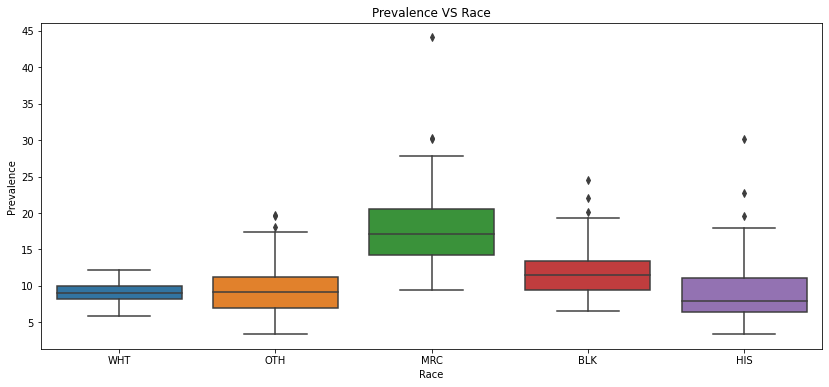

In [14]:
plt.figure(figsize = (14, 6))
prevalence_race = prevalence_final[prevalence_final['StratificationCategory'] == 'RACE']
sns.boxplot(x = 'Stratification', y = 'Prevalence', data = prevalence_race)
plt.xlabel('Race')
plt.title('Prevalence VS Race')

When examining the boxplot between prevalance and race, we see multiracial (MRC) having the highest upperbound and outlier.\
One thing to note is that gender and race has no data reflecting their potential relationship hence when modeling, we either separate them or choose one.

3) Asthma: location/state

<AxesSubplot:xlabel='StateID', ylabel='Prevalence'>

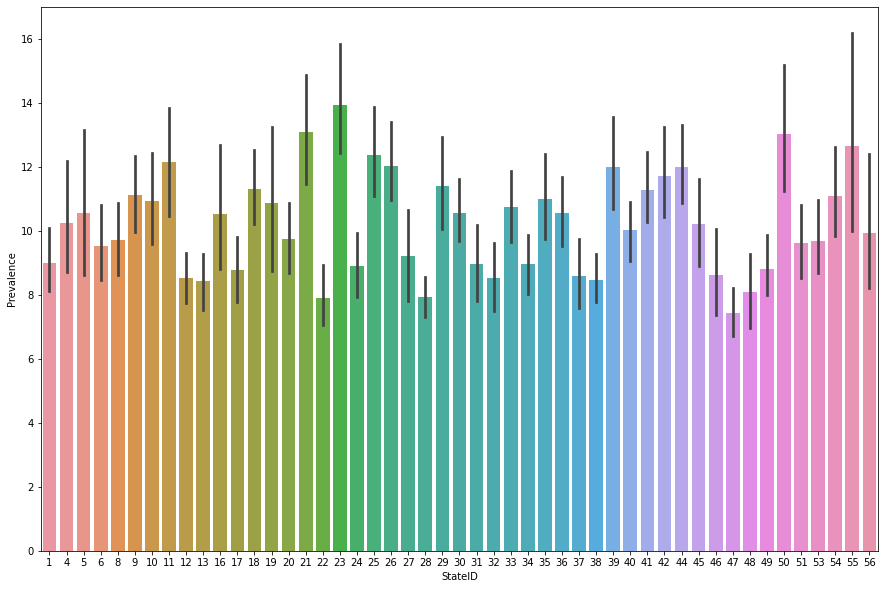

In [15]:
### Add into abbreviations
plt.figure(figsize = (15, 10))

sns.barplot(x = 'StateID', y = 'Prevalence', data = prevalence_final)

We see varying mortality/prevalence of asthma across states, thus we want to include state as a confounding variable when predicting future pm2.5/ozone level on asthma prevalence/mortality.

In [16]:
new = prevalence_race.groupby(['State','Stratification']).size().to_frame().reset_index().pivot(index='State', columns='Stratification', values=0).fillna(0)

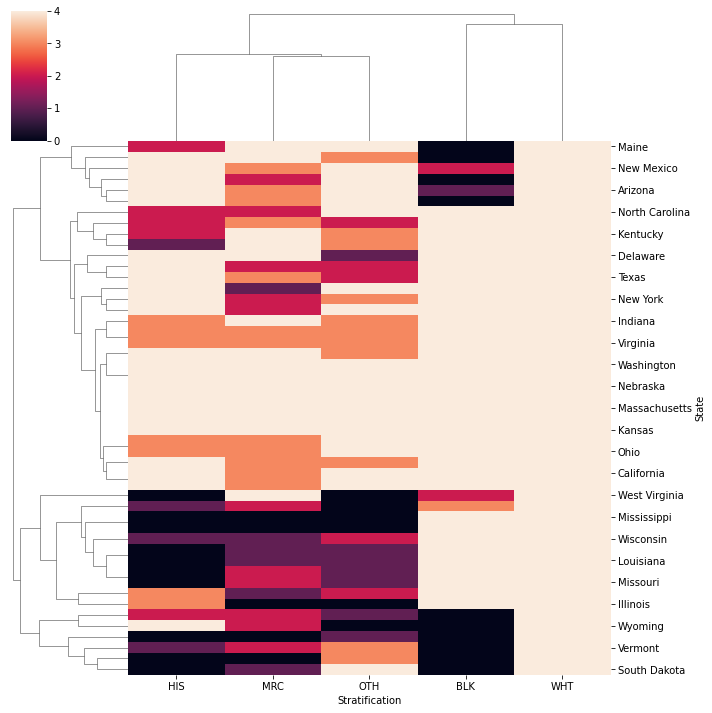

In [17]:
sns.clustermap(new)

From the clustered heatmap above, we see unequal distribution of race along different states. Thus, we are interested in examining the relationship between race and geography, which may both serve as a confounding variable to asthma prevalence/mortality.

4) PM2.5 and ozone

<AxesSubplot:xlabel='PM2.5', ylabel='Ozone'>

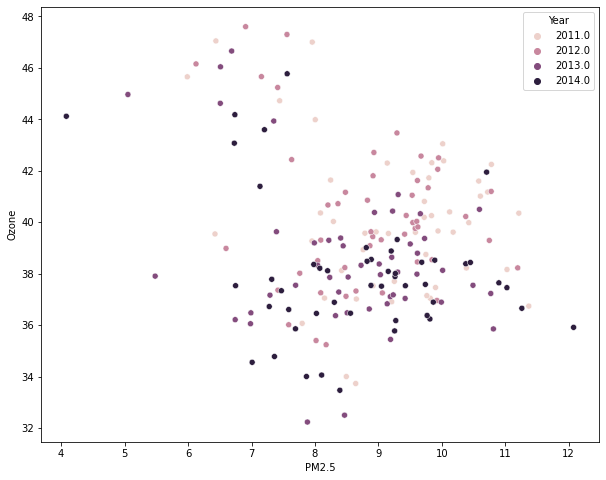

In [18]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x='PM2.5', y='Ozone', data=pm25_ozone, hue='Year')

When examining the scatterplot between Ozone and pm2.5 level, we see no distinct relationship as shown by the ramdomized pattern. Thus, when evaluating their effects on prevalence of asthma, it is reasonable that we separate them into distinct random variables.

5) Asthma, PM2.5 and ozone

Text(0.5, 1.0, 'Prevalence VS Ozone level')

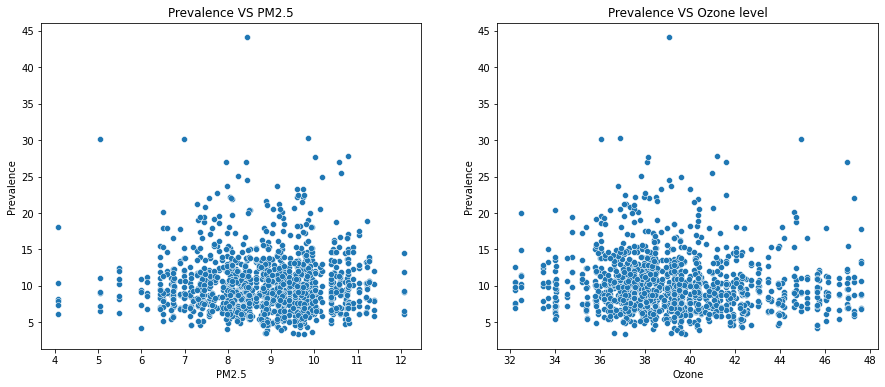

In [19]:
plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='PM2.5', y='Prevalence', data=prevalence_final)
plt.title('Prevalence VS PM2.5')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Ozone', y='Prevalence', data=prevalence_final)
plt.title('Prevalence VS Ozone level')

When examining the scatter plot above, we don't see clear pattern between prevalence of asthma/mortality rate versus onzone/pm2.5. However, there may exist various confounding variables that influence the overall trend, for example location(state), year, as well as gender and race.

In [20]:
prevalence_gender.head()

,Year,State,StateID,Prevalence,StratificationCategory,Stratification,PM2.5,Ozone
0,2013,Utah,49,7.2,GENDER,GENM,9.311432,41.073701
17,2014,Colorado,8,5.9,GENDER,GENM,6.737662,44.177632
24,2012,Colorado,8,10.7,GENDER,GENF,6.906790,47.597103
28,2012,Colorado,8,7.0,GENDER,GENM,6.906790,47.597103
31,2014,Colorado,8,10.9,GENDER,GENF,6.737662,44.177632


<AxesSubplot:xlabel='Ozone', ylabel='Prevalence'>

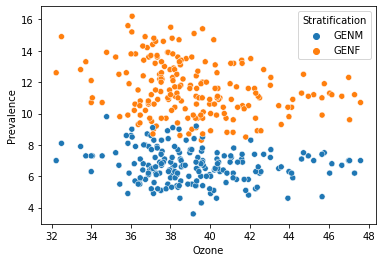

In [21]:
sns.scatterplot(data=prevalence_gender, x = 'Ozone', y = 'Prevalence', hue='Stratification')

(0.0, 30.0)

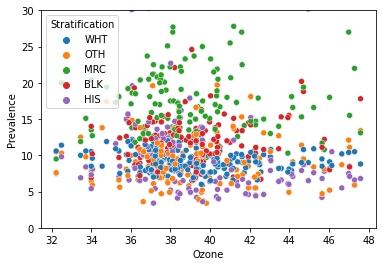

In [22]:
sns.scatterplot(data=prevalence_race, x = 'Ozone', y = 'Prevalence', hue='Stratification')
plt.ylim(0, 30)

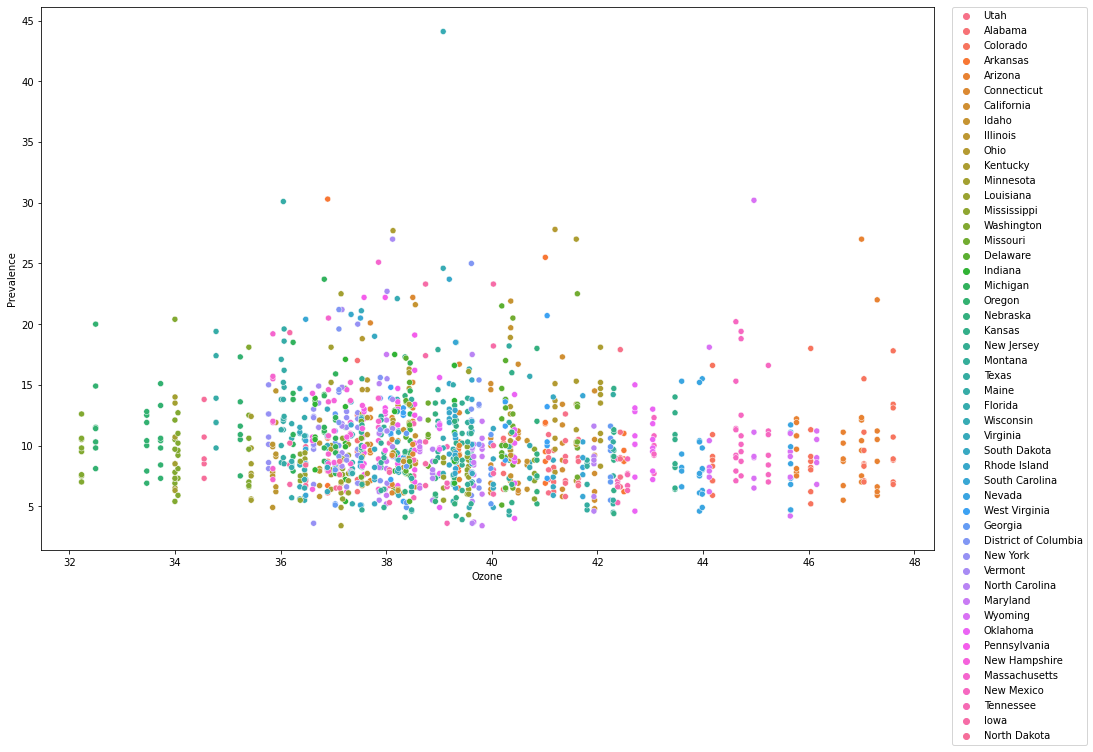

In [23]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=prevalence_final, x = 'Ozone', y = 'Prevalence', hue='State')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

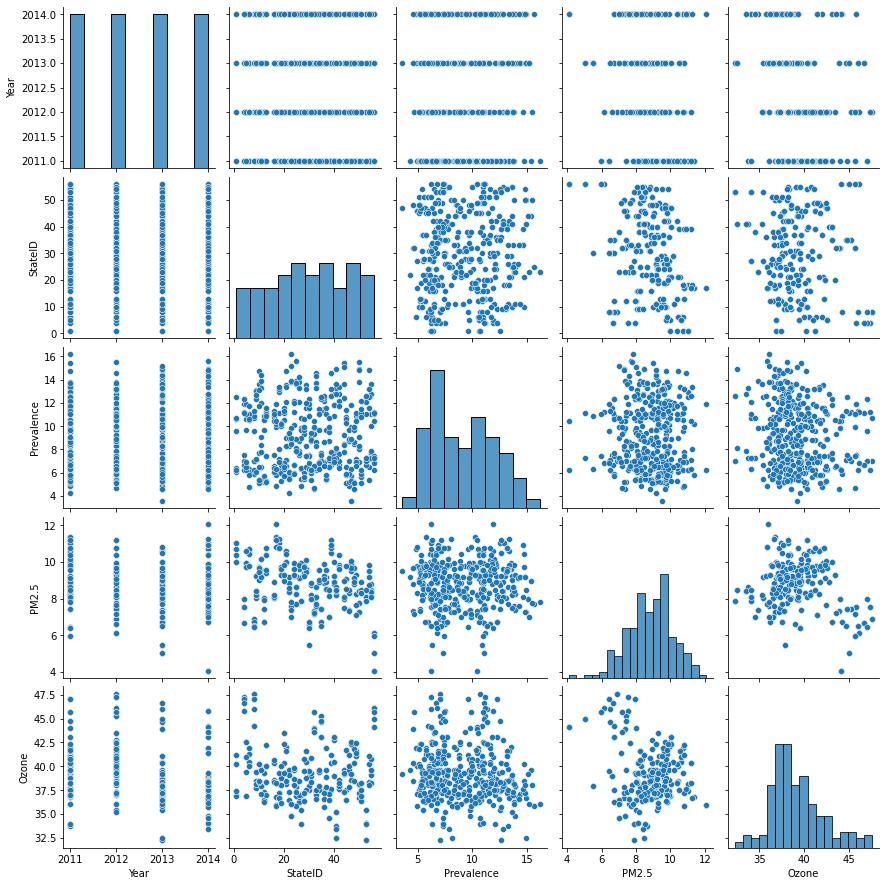

In [24]:
sns.pairplot(prevalence_gender)

# Research Question 1: What's the causal impact of ozone level on age-adjusted asthma prevalence?

(Due to the limitation of the asthma data set, we can't control for race and gender at the same time for our model, so we will control for race and gender seperately in our analysis)

### Model Setup
- Treatment variable Z: Ozone level
- Outcome variable Y: Age-adjusted Prevalence of Asthma
- Confounders: location, gender/race, PM2.5
- We assume that the unconfoundedness assumption holds. In other words, location, gender/race and PM2.5 are the only confounders in this problem.
- There is no collider in the dataset


### Here are some methods we would use in this section.

In [25]:
### This function below is adapted from Lab7
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [26]:
### This function below is adapted from Lab8
def RMSE(true_vals, predicted_vals):
    """
    Return the mean squared error
    
    Inputs:
        true_vals: array of true labels
        predicted_vals: array labels predicted from the data
    Output:
        float, mean squared error of the predicted values
    """
    return np.mean((true_vals - predicted_vals) ** 2) ** 0.5

In [27]:
def encode_and_bind(original_dataframe, feature_to_encode):
    """
    One-hot encoding for deature
    """
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

## Part A. We first try controlling for confounding variables by fitting a GLM model.

First, let's look at the relationship between prevalence Ozone, and PM2.5 directly.\
The model we fit is in the following form: Prevalence = $\alpha$ + $\tau*Z + b*PM2.5$


In [28]:
model_prevalence_pm = fit_OLS_model(prevalence_final, 'Prevalence', ['Ozone'], intercept = True)
print(model_prevalence_pm.summary())

                            OLS Regression Results                            
Dep. Variable:             Prevalence   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.224
Date:                Thu, 09 Dec 2021   Prob (F-statistic):             0.0127
Time:                        19:20:31   Log-Likelihood:                -3662.4
No. Observations:                1313   AIC:                             7329.
Df Residuals:                    1311   BIC:                             7339.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8163      1.430      9.661      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



This is not a good model since its log-likelihood is far from 0 and its coefficient on PM2.5 is not statistically significant. 

From previous EDA part, we know that ...
- "When examining the boxplot between prevalance and race, we see multiracial (MRC) having the highest upperbound and outlier."
- "We see varying adge-adjusted prevalence of asthma across states." 
 
Thus, we draw a directed acyclic graph (DAG) to capture the casual relationship between variables.

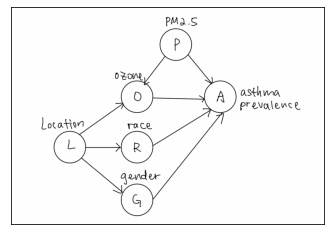

In [29]:
import matplotlib.image as mpimg
img = mpimg.imread('dag.png', )
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)

Here we see that both race and gender act as confounding variables for asthma prevalence. We want to control for both. However, since race and gender are mutually exclusive, we fit separate linear regression.
Thus, we examine the effect of PM2.5 on asthma prevalence by controlling for either race or gender.

### a) We start by first conducting one-hot encoding on race/gender/location

In [30]:
# One-hot encoding for race
prevalence_race_onehot = encode_and_bind(prevalence_race, 'Stratification')
prevalence_race_onehot = prevalence_race_onehot.rename(columns={'Stratification_BLK':'BLK','Stratification_HIS':'HIS',
                                                'Stratification_MRC':'MRC', 'Stratification_OTH':'OTH',
                                                'Stratification_WHT':'WHT'})
prevalence_race_onehot.head(5)

,Year,State,StateID,Prevalence,StratificationCategory,PM2.5,Ozone,BLK,HIS,MRC,OTH,WHT
1,2014,Alabama,1,9.5,RACE,11.025839,37.455517,0,0,0,0,1
2,2014,Colorado,8,9.1,RACE,6.737662,44.177632,0,0,0,1,0
3,2011,Colorado,8,15.5,RACE,6.438329,47.043940,0,0,1,0,0
4,2011,Arkansas,5,25.5,RACE,10.607418,41.012629,0,0,1,0,0
5,2012,Arkansas,5,8.9,RACE,9.948684,42.500444,1,0,0,0,0


In [31]:
# One-hot encoding for gender
prevalence_gender_onehot = encode_and_bind(prevalence_gender, 'Stratification')
prevalence_gender_onehot = prevalence_gender_onehot.rename(columns={'Stratification_GENF':'Female','Stratification_GENM':'Male'})
prevalence_gender_onehot.head(5)

,Year,State,StateID,Prevalence,StratificationCategory,PM2.5,Ozone,Female,Male
0,2013,Utah,49,7.2,GENDER,9.311432,41.073701,0,1
17,2014,Colorado,8,5.9,GENDER,6.737662,44.177632,0,1
24,2012,Colorado,8,10.7,GENDER,6.906790,47.597103,1,0
28,2012,Colorado,8,7.0,GENDER,6.906790,47.597103,0,1
31,2014,Colorado,8,10.9,GENDER,6.737662,44.177632,1,0


In [32]:
# One-hot encoding for location
prevalence_state_onehot = encode_and_bind(prevalence_final, 'State')
prevalence_state_onehot.head(5)

,Year,StateID,Prevalence,StratificationCategory,Stratification,PM2.5,Ozone,State_Alabama,State_Arizona,State_Arkansas,...,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
0,2013,49,7.2,GENDER,GENM,9.311432,41.073701,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2014,1,9.5,RACE,WHT,11.025839,37.455517,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014,8,9.1,RACE,OTH,6.737662,44.177632,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011,8,15.5,RACE,MRC,6.438329,47.043940,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011,5,25.5,RACE,MRC,10.607418,41.012629,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# One-hot both state and race
prevalence_race_state_onehot = encode_and_bind(prevalence_race_onehot, 'State')
prevalence_race_state_onehot.head()

,Year,StateID,Prevalence,StratificationCategory,PM2.5,Ozone,BLK,HIS,MRC,OTH,...,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
1,2014,1,9.5,RACE,11.025839,37.455517,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014,8,9.1,RACE,6.737662,44.177632,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2011,8,15.5,RACE,6.438329,47.043940,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2011,5,25.5,RACE,10.607418,41.012629,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,2012,5,8.9,RACE,9.948684,42.500444,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
print(prevalence_race_state_onehot.columns)

Index(['Year', 'StateID', 'Prevalence', 'StratificationCategory', 'PM2.5',
       'Ozone', 'BLK', 'HIS', 'MRC', 'OTH', 'WHT', 'State_Alabama',
       'State_Arizona', 'State_Arkansas', 'State_California', 'State_Colorado',
       'State_Connecticut', 'State_Delaware', 'State_District of Columbia',
       'State_Florida', 'State_Georgia', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State

In [35]:
# One-hot both state and gender
prevalence_gender_state_onehot = encode_and_bind(prevalence_gender_onehot, 'State')
prevalence_gender_state_onehot.head()

,Year,StateID,Prevalence,StratificationCategory,PM2.5,Ozone,Female,Male,State_Alabama,State_Arizona,...,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
0,2013,49,7.2,GENDER,9.311432,41.073701,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
17,2014,8,5.9,GENDER,6.737662,44.177632,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24,2012,8,10.7,GENDER,6.906790,47.597103,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,2012,8,7.0,GENDER,6.906790,47.597103,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
31,2014,8,10.9,GENDER,6.737662,44.177632,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
print(prevalence_gender_state_onehot.columns)

Index(['Year', 'StateID', 'Prevalence', 'StratificationCategory', 'PM2.5',
       'Ozone', 'Female', 'Male', 'State_Alabama', 'State_Arizona',
       'State_Arkansas', 'State_California', 'State_Colorado',
       'State_Connecticut', 'State_Delaware', 'State_District of Columbia',
       'State_Florida', 'State_Georgia', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_U

### b) We now fit the linear regression models
Since we have panel data, we want to omit variable BLK, and Male to prevent perfect multicollinearity

#### i) We examine the casual effect of Ozone on age-adjusted asthma prevalence by controlling for location and PM2.5

We first control for location because according to our DAG, controlling for location satisfies backdoor criterion and can block every path to asthma prevalence (ie. gender/race) except the path from ozone to prevalence.\
We also control for PM2.5 because PM2.5 is a confounder in investigating the causal relationship between ozone and asthma prevalence.

In [37]:
model_prevalence_pm_loc = fit_OLS_model(prevalence_state_onehot, 'Prevalence', ['Ozone','PM2.5','State_Arizona',
       'State_Arkansas', 'State_California', 'State_Colorado',
       'State_Connecticut', 'State_Delaware', 'State_District of Columbia',
       'State_Florida', 'State_Georgia', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming'], intercept = True)
print(model_prevalence_pm_loc.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



                            OLS Regression Results                            
Dep. Variable:             Prevalence   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     4.397
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           6.56e-21
Time:                        19:20:32   Log-Likelihood:                -3560.1
No. Observations:                1313   AIC:                             7222.
Df Residuals:                    1262   BIC:                             7486.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

The p-value for the coefficient for ozone is very large, and the log-likelihood is also very large, indicating that this model is not ideal. Therefore, we will then control for race/gender in our analysis below.

#### ii) We examine the casual effect of Ozone on age-adjusted asthma prevalence by controlling for race and PM2.5

The model is in the following form: Prevalence = $\alpha$ + $\tau*Z$ + $b*$PM2.5 + $c*$HIS + $d*$MRC + $e*$OTH + $f*$WHT

In [38]:
# Omitting BLK variable (for panel data)
model_prevalence_pm_race = fit_OLS_model(prevalence_race_onehot, 'Prevalence', ['Ozone','PM2.5','HIS', 'MRC', 
                                                                             'OTH', 'WHT'], intercept = True)
print(model_prevalence_pm_race.summary())

                            OLS Regression Results                            
Dep. Variable:             Prevalence   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     108.6
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.94e-97
Time:                        19:20:32   Log-Likelihood:                -1907.8
No. Observations:                 725   AIC:                             3830.
Df Residuals:                     718   BIC:                             3862.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.2845      2.101      7.276      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [39]:
model_prevalence_pm_race_no_intercept = fit_OLS_model(prevalence_race_onehot, 'Prevalence', 
                                                      ['Ozone',"PM2.5", 'HIS', 'MRC', 'OTH', 'WHT'])

In [40]:
model_prevalence_pm_race_predicted = model_prevalence_pm_race_no_intercept.predict(prevalence_race_onehot[[
                                                          'Ozone',"PM2.5",'HIS','MRC','OTH','WHT']]).values
err = RMSE(prevalence_race_onehot['Prevalence'].values, model_prevalence_pm_race_predicted)
err

3.4835520063555636

We see the model has a log-likelihood closer to 0 compared to the previous model and the coefficient for ozone is statistically significant at 10% significance level.

#### iii) We examine the casual effect of Ozone on age-adjusted asthma prevalence by controlling for gender and PM2.5

The model is in the following form: Prevalence = $\alpha$ + $\tau*Z + b*PM2.5 + c*Female$

In [41]:
model_prevalence_pm_gender = fit_OLS_model(prevalence_gender_onehot, 'Prevalence', ['Ozone','PM2.5', 'Female'], 
                                           intercept = True)
print(model_prevalence_pm_gender.summary())

                            OLS Regression Results                            
Dep. Variable:             Prevalence   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     409.4
Date:                Thu, 09 Dec 2021   Prob (F-statistic):          8.49e-120
Time:                        19:20:32   Log-Likelihood:                -686.62
No. Observations:                 392   AIC:                             1381.
Df Residuals:                     388   BIC:                             1397.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0962      1.181     10.246      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



The Log-likelihood is even closer to 0. And the coefficient of Ozone is statistically significant in both linear regression models with a p-value less than 0.05.

**Result:** There is casual relationship between ozone and age-adjusted prevalence rate of asthma. The last two model suggest that one unit increase in the ozone level causes age-adjusted prevalence to decrease by 0.07 and 0.11 respectively.

## Part B. We try controlling for confounding variables by Inverse Propensity Weighting.

To apply IPW, we need to deternmine a binary treatment variable. We accomplish this by calculating the difference of PM2.5 and ozone levels between 2011 and 2014. By setting a threshold of -2, we divide the dataset into treatment and control groups that have approximately the same size.

In [42]:
prevalence_2011 = prevalence_final[prevalence_final['Year'] == 2011]
prevalence_2014 = prevalence_final[prevalence_final['Year'] == 2014]
prevalence_2014[prevalence_2014['State'] == 'Missouri']

,Year,State,StateID,Prevalence,StratificationCategory,Stratification,PM2.5,Ozone
452,2014,Missouri,29,9.6,RACE,WHT,9.425226,37.530147
556,2014,Missouri,29,11.6,RACE,BLK,9.425226,37.530147
955,2014,Missouri,29,9.8,OVERALL,OVR,9.425226,37.530147
1144,2014,Missouri,29,12.0,GENDER,GENF,9.425226,37.530147
1205,2014,Missouri,29,7.4,GENDER,GENM,9.425226,37.530147
1282,2014,Missouri,29,10.6,RACE,OTH,9.425226,37.530147


In [43]:
prevalence_2011_2014 = pd.merge(prevalence_2011, prevalence_2014, how='left', on=['State','StateID', 'StratificationCategory', 
                                                                                  'Stratification'])
p = prevalence_2011_2014.rename(columns={'PM2.5_x':'PM2.5_2011','PM2.5_y':'PM2.5_2014',
                                        'Ozone_x':'Ozone_2011', 'Ozone_y':'Ozone_2014',
                                        'Prevalence_x':'Prevalence_2011', 'Prevalence_y':'Prevalence_2014'})
p['Prevalence_diff'] = p['Prevalence_2014'] - p['Prevalence_2011']
p['Ozone_diff'] = p['Ozone_2014'] - p['Ozone_2011']
p['PM2.5_diff'] = p['PM2.5_2014'] - p['PM2.5_2011']
p.head()

,Year_x,State,StateID,Prevalence_2011,StratificationCategory,Stratification,PM2.5_2011,Ozone_2011,Year_y,Prevalence_2014,PM2.5_2014,Ozone_2014,Prevalence_diff,Ozone_diff,PM2.5_diff
0,2011,Colorado,8,15.5,RACE,MRC,6.438329,47.043940,2014.0,16.6,6.737662,44.177632,1.1,-2.866308,0.299333
1,2011,Arkansas,5,25.5,RACE,MRC,10.607418,41.012629,2014.0,30.3,9.865337,36.892805,4.8,-4.119824,-0.742082
2,2011,Connecticut,9,20.1,RACE,MRC,9.250752,37.700337,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,California,6,6.9,RACE,OTH,10.424960,39.981360,2014.0,5.5,10.705496,41.944996,-1.4,1.963636,0.280536
4,2011,Colorado,8,11.1,RACE,OTH,6.438329,47.043940,2014.0,9.1,6.737662,44.177632,-2.0,-2.866308,0.299333


In [44]:
selected_col = ['State', 'StateID', 'StratificationCategory', 'Stratification', 'Prevalence_diff', 'Ozone_diff', 'PM2.5_diff']
p_final = p[selected_col]
p_final['Ozone_treatment'] = p_final['Ozone_diff'].apply(lambda x: 1 if x > -2 else 0)
p_final.head(5)

,State,StateID,StratificationCategory,Stratification,Prevalence_diff,Ozone_diff,PM2.5_diff,Ozone_treatment
0,Colorado,8,RACE,MRC,1.1,-2.866308,0.299333,0
1,Arkansas,5,RACE,MRC,4.8,-4.119824,-0.742082,0
2,Connecticut,9,RACE,MRC,NaN,NaN,NaN,0
3,California,6,RACE,OTH,-1.4,1.963636,0.280536,1
4,Colorado,8,RACE,OTH,-2.0,-2.866308,0.299333,0


We decide to use gender/race PM2.5 to compute our propensity score instead of location because there will be 50 mores parameters if we perform one-hot encoding on location, which will affect the degree of freedom. Moreover, according to our analysis above, the model that used location has the most negative log-likelihood.

### 1) Propensity score controlling gender and PM2.5

In [45]:
# One-hot encoding
def encode_and_bind(original_dataframe, feature_to_encode):
    """
    One-hot encoding for deature
    """
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [46]:
# One-hot encoding of gender
p_gender = p_final[p_final['StratificationCategory'] == 'GENDER']
p_gender = encode_and_bind(p_gender, 'Stratification')

In [47]:
# Select useful columns for our analysis
cols = ['Ozone_treatment', 'State', 'StateID', 'StratificationCategory', 'Prevalence_diff', 'Stratification_GENF',
        'PM2.5_diff']
p_gender_edited = p_gender[cols]
p_gender_edited.head()

,Ozone_treatment,State,StateID,StratificationCategory,Prevalence_diff,Stratification_GENF,PM2.5_diff
21,1,California,6,GENDER,-1.3,0,0.280536
22,1,Connecticut,9,GENDER,-1.0,0,-1.051404
24,0,Alabama,1,GENDER,2.9,1,0.303445
28,1,California,6,GENDER,-0.1,1,0.280536
29,1,Connecticut,9,GENDER,-0.7,1,-1.051404


In [48]:
from sklearn.linear_model import LogisticRegression as LR 
lr = LR(penalty='none', max_iter=200, random_state=0)
y = p_gender_edited['Prevalence_diff']
z = p_gender_edited['Ozone_treatment']
x = np.array([i.tolist()[-2:] for i in p_gender_edited.values], dtype='float')
lr.fit(x, z)

LogisticRegression(max_iter=200, penalty='none', random_state=0)

In [49]:
def estimate_treatment_effect(model, X, Y, Z):
    ex = model.predict_proba(X)[:, 1]
    return np.mean(Z * Y / ex) - np.mean((1 - Z) * Y / (1 - ex))

Below is the propensity score distribution:

(array([ 4.,  8.,  8.,  8., 18., 28.,  8.,  8.,  4.,  4.]),
 array([0.4808014, 0.4867496, 0.4926978, 0.498646 , 0.5045942, 0.5105424,
        0.5164906, 0.5224388, 0.528387 , 0.5343352, 0.5402834]),
 <BarContainer object of 10 artists>)

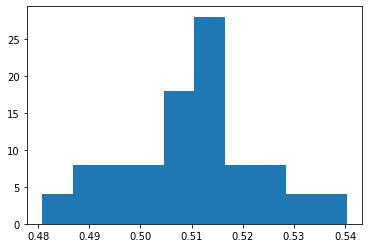

In [50]:
plt.hist(lr.predict_proba(x)[:, 1])

In [51]:
tau = estimate_treatment_effect(lr, x, y, z)
tau

-0.21882269835373558

**Result:** The estimated treatment effect is approximately -0.176, implying that ozone level has a negative causal effect on the asthma prevalence. This means that the differece in ozone level between 2014 and 2011 decreased asthma prevalence by -0.176.

### 2) Propensity score controlling race and PM2.5

In [52]:
p_race = p_final[p_final['StratificationCategory'] == 'RACE']
p_race = encode_and_bind(p_race, 'Stratification')
p_race = p_race.rename(columns={'Stratification_BLK':'BLK','Stratification_HIS':'HIS',
                                                'Stratification_MRC':'MRC', 'Stratification_OTH':'OTH',
                                                'Stratification_WHT':'WHT'})
p_race.columns

Index(['State', 'StateID', 'StratificationCategory', 'Prevalence_diff',
       'Ozone_diff', 'PM2.5_diff', 'Ozone_treatment', 'BLK', 'HIS', 'MRC',
       'OTH', 'WHT'],
      dtype='object')

In [53]:
p_race_edited = p_race[['Ozone_treatment', 'State', 'StateID', 'StratificationCategory', 'Prevalence_diff',
                        'Ozone_diff', 'PM2.5_diff', 'HIS', 'MRC','OTH', 'WHT']]
p_race_edited = p_race_edited.dropna()
p_race_edited.head()

,Ozone_treatment,State,StateID,StratificationCategory,Prevalence_diff,Ozone_diff,PM2.5_diff,HIS,MRC,OTH,WHT
0,0,Colorado,8,RACE,1.1,-2.866308,0.299333,0,1,0,0
1,0,Arkansas,5,RACE,4.8,-4.119824,-0.742082,0,1,0,0
3,1,California,6,RACE,-1.4,1.963636,0.280536,0,0,1,0
4,0,Colorado,8,RACE,-2.0,-2.866308,0.299333,0,0,1,0
5,1,Connecticut,9,RACE,-1.8,0.411285,-1.051404,1,0,0,0


In [54]:
y = p_race_edited['Prevalence_diff']
z = p_race_edited['Ozone_treatment']
x = np.array([i.tolist()[-5:] for i in p_race_edited.values], dtype='float')
lr.fit(x, z)

LogisticRegression(max_iter=200, penalty='none', random_state=0)

(array([ 6., 26., 15., 47., 27., 15.,  1.,  2., 13., 13.]),
 array([0.41008598, 0.43620732, 0.46232866, 0.48845   , 0.51457134,
        0.54069268, 0.56681402, 0.59293536, 0.6190567 , 0.64517804,
        0.67129938]),
 <BarContainer object of 10 artists>)

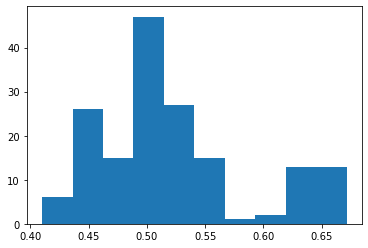

In [55]:
plt.hist(lr.predict_proba(x)[:, 1])

In [56]:
tau = estimate_treatment_effect(lr, x, y, z)
tau

0.13236411917522636

**Result:** The estimated treatment effect is approximately 0.177, implying that ozone level has a positive causal effect on the asthma prevalence. This means that the differece in ozone level between 2014 and 2011 increased asthma prevalence by 0.177.

According to our research on scientific studies, we believe that the ATE calculated when we controlled for race and PM2.5 is more reliable. Moreover, location has more influence on race compared to gender. And acoording to our scatterplot on prevalence and ozone (seperated by race), race seems to have a greater effect on ozone level compared to gender, therefore it is be a better variable to be controlled to invetigate ATE.

## Results

Assume unconfoundedness,
1. According to our linear regression model, one unit increase in the ozone level causes prevalence to decrease by 0.1
2. According to our Inverse Propensity Weighting method on gender and PM2.5, one unit increase in ozone level decrease the asthma prevalence by 0.18
3. According to our Inverse Propensity Weighting method on race and PM2.5, one unit increase in ozone level increase the asthma prevalence by 0.18

The fact that most of our model suggests that ozone level has a negative causal effect on asthma prevalance seems counterintuitive becuase higher ozone level is irritating to the lungs and airways and therefore is more likely to trigger asthma.\
Therefore, our models are not reliable, primarily because we lack data on other possible confounders such as age/smoking.

***Table to be inserted***

## Discussion

Limitations:
1. There may be other confounders such as health condition/smoking that may affect the age-adjusted prevalence of asthma. However, we don't have these data and therefore can't control for them in our model. This implies that the unconfoundedness assumption may be violated.
2. Location, gender and race may not be good confounders to be controlled for in this model.
3. Inverse Propensity Weighting may not be a good method to investigate causal relationship between ozone level and asthma prevalence becuase there is no natural treatment group and control group and therefore we have to manually divide the data into two groups.
4. Linear regression model may not be a good model to use in this case because we are not sure that ozone level, asthma prevalence and other confounding variables has a linear relationship.
5. After our research, we found out that temperature directly influences ozone production. Thus, to better analyze the causal impact of the ozone level on the prevalence of asthma, we should examine the data seasonally. However, we now only have the yearly prevalence of asthma, and after we average the ozone level over a year, the fluctuations of ozone level are averaged out. And then, it makes sense that we can't find a clear causal relationship.

Other data that might be useful:
1. Average age/proportion of participates that smoke to be used as controlled variables in the model
2. Possible instrumental variables for ozone level such as temperature
3. Monthly asthma data to analyze the causal impact over a season
4. Other numerical data about state eg.the number of factories in each state

We are not confident that there is a causal relationship between ozone level and asthma because there are so many confounders that need to be controlled for in order to accurately estimate the causal effect. 

# Research Question 2: Given the selected features, build a model that can predict the age-adjusted prevalence of Asthma.

## 1. When control for race, divide the dataset into training and testing set and build models that can predict the age-adjusted prevalence of Asthma. 

### Prediction with Frequentist GLM

In [57]:
prevalence_race_state_onehot2 =  prevalence_race_state_onehot.rename(columns={'PM2.5':'PM25'})
prevalence_race_state_onehot3 = prevalence_race_state_onehot2[['Prevalence','PM25',
       'Ozone', 'BLK', 'HIS', 'MRC', 'OTH', 'WHT', 'State_Alabama',
       'State_Arizona', 'State_Arkansas', 'State_California', 'State_Colorado',
       'State_Connecticut', 'State_Delaware', 'State_District of Columbia',
       'State_Florida', 'State_Georgia', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming']]
prevalence_race_state_onehot3 = prevalence_race_state_onehot3.rename(columns={
        'State_District of Columbia':'State_District_of_Columbia','State_New Hampshire':'State_New_Hampshire',
        'State_New Jersey':'State_New_Jersey', 'State_New Mexico':'State_New_Mexico', 'State_New York':'State_New_York',
        'State_North Carolina':'State_North_Carolina', 'State_North Dakota':'State_North_Dakota',
        'State_Rhode Island':'State_Rhode_Island', 'State_South Carolina':'State_South_Carolina', 
        'State_South Dakota':'State_South_Dakota', 'State_West Virginia':'State_West_Virginia'})


In [58]:
from sklearn.model_selection import train_test_split
train1, test1 = train_test_split(prevalence_race_state_onehot3, test_size=0.3, random_state=102)

In [59]:
train1.head(5)

,Prevalence,PM25,Ozone,BLK,HIS,MRC,OTH,WHT,State_Alabama,State_Arizona,...,State_South_Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West_Virginia,State_Wisconsin,State_Wyoming
768,11.5,9.682943,38.442977,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
525,14.1,9.795626,41.722261,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
817,13.0,8.855819,36.626529,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
573,9.0,8.246603,41.636938,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
484,25.0,10.178120,39.612826,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
import statsmodels.formula.api as smf

### Frequentist GLM with Gaussian family (race)

In [61]:
train1 = sm.add_constant(train1)
model_race = smf.glm(formula='Prevalence ~ PM25 + Ozone + HIS + MRC + OTH + WHT', data=train1, 
                     family=sm.families.Gaussian())
gaussian_results_race = model_race.fit()
print(gaussian_results_race.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Prevalence   No. Observations:                  507
Model:                            GLM   Df Residuals:                      500
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          11.061
Method:                          IRLS   Log-Likelihood:                -1325.2
Date:                Thu, 09 Dec 2021   Deviance:                       5530.6
Time:                        19:20:34   Pearson chi2:                 5.53e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.6858      2.450      6.402      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [62]:
test1 = sm.add_constant(test1)

print("Training set error for GLM with Gaussian family (race):", RMSE(train1['Prevalence'],gaussian_results_race.predict(train1)))
print("Test set error for GLM with Gaussian family (race):    ", RMSE(test1['Prevalence'],gaussian_results_race.predict(test1)))

Training set error for GLM with Gaussian family (race): 3.302801444808495
Test set error for GLM with Gaussian family (race):     3.5050811984059407


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



### Frequentist GLM with Gaussian family (race + state)

In [63]:
# Gaussian
model_race_state = smf.glm(formula='Prevalence ~ PM25 + Ozone + HIS + MRC + OTH + WHT + State_Arizona\
                           + State_Arkansas + State_California + State_Colorado + State_Connecticut \
                           + State_Delaware + State_District_of_Columbia + State_Florida + State_Georgia\
                           + State_Idaho + State_Illinois + State_Indiana + State_Iowa + State_Kansas\
                           + State_Kentucky + State_Louisiana + State_Maine + State_Maryland + State_Massachusetts\
                           + State_Michigan + State_Minnesota + State_Mississippi + State_Missouri + State_Montana\
                           + State_Nebraska + State_Nevada + State_New_Hampshire + State_New_Jersey + State_New_Mexico\
                           + State_New_York + State_North_Carolina + State_North_Dakota + State_Ohio + State_Oklahoma\
                           + State_Oregon + State_Pennsylvania + State_Rhode_Island + State_South_Carolina\
                           + State_South_Dakota + State_Tennessee + State_Texas + State_Utah + State_Vermont\
                           + State_Virginia + State_Washington + State_West_Virginia + State_Wisconsin + State_Wyoming',
                           data=train1, family=sm.families.Gaussian())

In [64]:
gaussian_results_race_state = model_race_state.fit()
print(gaussian_results_race_state.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Prevalence   No. Observations:                  507
Model:                            GLM   Df Residuals:                      452
Model Family:                Gaussian   Df Model:                           54
Link Function:               identity   Scale:                          8.7395
Method:                          IRLS   Log-Likelihood:                -1239.8
Date:                Thu, 09 Dec 2021   Deviance:                       3950.3
Time:                        19:20:34   Pearson chi2:                 3.95e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [65]:
print("Training set error for GLM with Gaussian family (race + state):", RMSE(train1['Prevalence'],gaussian_results_race_state.predict(train1)))
print("Test set error for GLM with Gaussian family (race + state):    ", RMSE(test1['Prevalence'],gaussian_results_race_state.predict(test1)))

Training set error for GLM with Gaussian family (race + state): 2.791316434161281
Test set error for GLM with Gaussian family (race + state):     3.1829958216808545


###  Frequentist GLM with Gamma family (race + state)

In [66]:
model_race_state_gamma = smf.glm(formula='Prevalence ~ PM25 + Ozone + HIS + MRC + OTH + WHT + State_Arizona\
                           + State_Arkansas + State_California + State_Colorado + State_Connecticut \
                           + State_Delaware + State_District_of_Columbia + State_Florida + State_Georgia\
                           + State_Idaho + State_Illinois + State_Indiana + State_Iowa + State_Kansas\
                           + State_Kentucky + State_Louisiana + State_Maine + State_Maryland + State_Massachusetts\
                           + State_Michigan + State_Minnesota + State_Mississippi + State_Missouri + State_Montana\
                           + State_Nebraska + State_Nevada + State_New_Hampshire + State_New_Jersey + State_New_Mexico\
                           + State_New_York + State_North_Carolina + State_North_Dakota + State_Ohio + State_Oklahoma\
                           + State_Oregon + State_Pennsylvania + State_Rhode_Island + State_South_Carolina\
                           + State_South_Dakota + State_Tennessee + State_Texas + State_Utah + State_Vermont\
                           + State_Virginia + State_Washington + State_West_Virginia + State_Wisconsin + State_Wyoming',
                           data=train1, family=sm.families.Gamma())

/opt/conda/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning:

The inverse_power link function does not respect the domain of the Gamma family.



In [67]:
gamma_results_race_state = model_race_state_gamma.fit()
print(gamma_results_race_state.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Prevalence   No. Observations:                  507
Model:                            GLM   Df Residuals:                      452
Model Family:                   Gamma   Df Model:                           54
Link Function:          inverse_power   Scale:                        0.062805
Method:                          IRLS   Log-Likelihood:                -1189.0
Date:                Thu, 09 Dec 2021   Deviance:                       29.110
Time:                        19:20:34   Pearson chi2:                     28.4
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [68]:
#train1["Gamma_glm_pred"] = gamma_results_race_state.predict(test1)
#test1["Gamma_glm_pred"] = gamma_results_race_state.predict(test1)

print("Training set error for GLM with Gamma family (race + state):", RMSE(train1['Prevalence'],gamma_results_race_state.predict(train1)))
print("Test set error for GLM with Gamma family (race + state):    ", RMSE(test1['Prevalence'],gamma_results_race_state.predict(test1)))

Training set error for GLM with Gamma family (race + state): 2.727772327836729
Test set error for GLM with Gamma family (race + state):     3.2905275623603294


### Prediction with non-parametric methods

#### 1) Decision Tree

In [134]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
X = train1[['PM25', 'Ozone', 'BLK', 'HIS', 'MRC', 'OTH',
       'WHT', 'State_Alabama', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District_of_Columbia', 'State_Florida',
       'State_Georgia', 'State_Idaho', 'State_Illinois', 'State_Indiana',
       'State_Iowa', 'State_Kansas', 'State_Kentucky', 'State_Louisiana',
       'State_Maine', 'State_Maryland', 'State_Massachusetts',
       'State_Michigan', 'State_Minnesota', 'State_Mississippi',
       'State_Missouri', 'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West_Virginia',
       'State_Wisconsin', 'State_Wyoming']]
y = train1["Prevalence"]
tree_model.fit(X,y)

train1["tree_pred"] = tree_model.predict(X) 
test1["tree_pred"] = tree_model.predict(test1[['PM25', 'Ozone', 'BLK', 'HIS', 'MRC', 'OTH',
       'WHT', 'State_Alabama', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District_of_Columbia', 'State_Florida',
       'State_Georgia', 'State_Idaho', 'State_Illinois', 'State_Indiana',
       'State_Iowa', 'State_Kansas', 'State_Kentucky', 'State_Louisiana',
       'State_Maine', 'State_Maryland', 'State_Massachusetts',
       'State_Michigan', 'State_Minnesota', 'State_Mississippi',
       'State_Missouri', 'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West_Virginia',
       'State_Wisconsin', 'State_Wyoming']])

In [70]:
train_rmse = np.mean((train1["tree_pred"] - train1["Prevalence"]) ** 2) ** 0.5
test_rmse = np.mean((test1["tree_pred"] - test1["Prevalence"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 0.0
Test set error for decision tree:     4.07082368871303


As we learned in class, decision tree can reach MSE of 0 for the training set. </br>
Decision Tree also produces an acceptable MSE, yet it's a little worse than linear regression model.

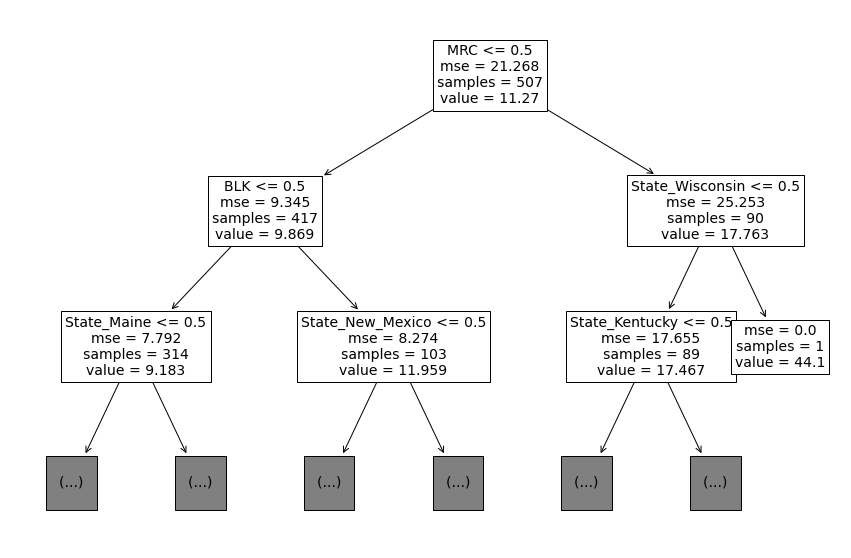

In [71]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 10))
plot_tree(tree_model, max_depth=2, fontsize=14,feature_names=[
       'PM25', 'Ozone', 'BLK', 'HIS', 'MRC', 'OTH',
       'WHT', 'State_Alabama', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District_of_Columbia', 'State_Florida',
       'State_Georgia', 'State_Idaho', 'State_Illinois', 'State_Indiana',
       'State_Iowa', 'State_Kansas', 'State_Kentucky', 'State_Louisiana',
       'State_Maine', 'State_Maryland', 'State_Massachusetts',
       'State_Michigan', 'State_Minnesota', 'State_Mississippi',
       'State_Missouri', 'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West_Virginia',
       'State_Wisconsin', 'State_Wyoming']);

#### 2) Random Forest

In [72]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(max_features=1)
forest_model.fit(X,y) 

train1["forest_pred"] = forest_model.predict(X) 
test1["forest_pred"] = forest_model.predict(test1[['PM25', 'Ozone', 'BLK', 'HIS', 'MRC', 'OTH',
       'WHT', 'State_Alabama', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District_of_Columbia', 'State_Florida',
       'State_Georgia', 'State_Idaho', 'State_Illinois', 'State_Indiana',
       'State_Iowa', 'State_Kansas', 'State_Kentucky', 'State_Louisiana',
       'State_Maine', 'State_Maryland', 'State_Massachusetts',
       'State_Michigan', 'State_Minnesota', 'State_Mississippi',
       'State_Missouri', 'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West_Virginia',
       'State_Wisconsin', 'State_Wyoming']]) 

In [73]:
train_rmse = np.mean((train1["forest_pred"] - train1["Prevalence"]) ** 2) ** 0.5
test_rmse = np.mean((test1["forest_pred"] - test1["Prevalence"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

Training set error for random forest: 1.1986312822091436
Test set error for random forest:     3.1814111331554025


Linear regression produce the model with the smallest test MSE, followed by Random Forest and Decision Tree.

### k-nearest neighbors

In [135]:
from sklearn import neighbors
k_val= np.arange(2, 20)
knn_train_rmse=[]
knn_test_rmse=[]
for k in k_val:
    knn=neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(X,y)
    train1["knn_pred"] = knn.predict(X) 
    test1["knn_pred"] = knn.predict(test1[['PM25', 'Ozone', 'BLK', 'HIS', 'MRC', 'OTH',
       'WHT', 'State_Alabama', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District_of_Columbia', 'State_Florida',
       'State_Georgia', 'State_Idaho', 'State_Illinois', 'State_Indiana',
       'State_Iowa', 'State_Kansas', 'State_Kentucky', 'State_Louisiana',
       'State_Maine', 'State_Maryland', 'State_Massachusetts',
       'State_Michigan', 'State_Minnesota', 'State_Mississippi',
       'State_Missouri', 'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West_Virginia',
       'State_Wisconsin', 'State_Wyoming']]) 
    train_rmse = RMSE(train1["Prevalence"],train1["knn_pred"])
    test_rmse = RMSE(test1["Prevalence"],test1["knn_pred"])
    knn_train_rmse.append(train_rmse)
    knn_test_rmse.append(test_rmse)

In [136]:
min(knn_train_rmse)

2.512428671698911

In [137]:
min(knn_test_rmse)

3.4936623029354297

Text(0, 0.5, 'RMSE')

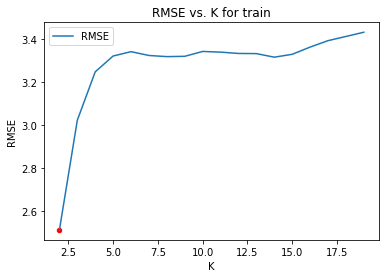

In [138]:
df=pd.DataFrame({'RMSE':knn_train_rmse, "K":k_val})
ax = df.plot(x='K')

(df.loc[[df['RMSE'].idxmin()]]
   .plot.scatter(x='K', y='RMSE',
                 color='r', ax=ax)
)

plt.title("RMSE vs. K for train")
plt.xlabel("K")
plt.ylabel("RMSE")

Text(0, 0.5, 'RMSE')

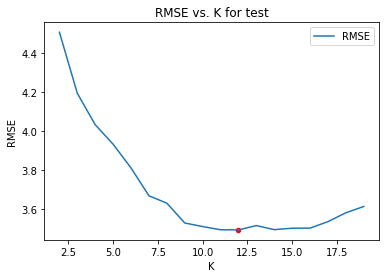

In [140]:
df=pd.DataFrame({'RMSE':knn_test_rmse, "K":k_val})
ax = df.plot(x='K')

(df.loc[[df['RMSE'].idxmin()]]
   .plot.scatter(x='K', y='RMSE',
                 color='r', ax=ax)
)

plt.title("RMSE vs. K for test")
plt.xlabel("K")
plt.ylabel("RMSE")

K = 12 generates the lowest RMSE for our test set.

In [79]:
# Show train RMSE and test RMSE when K = 12
KN_model = neighbors.KNeighborsRegressor(n_neighbors=12)
KN_model.fit(X,y)
train1["knn_pred"] = KN_model.predict(X) 
test1["knn_pred"] = KN_model.predict(test1[['PM25', 'Ozone', 'BLK', 'HIS', 'MRC', 'OTH',
       'WHT', 'State_Alabama', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_District_of_Columbia', 'State_Florida',
       'State_Georgia', 'State_Idaho', 'State_Illinois', 'State_Indiana',
       'State_Iowa', 'State_Kansas', 'State_Kentucky', 'State_Louisiana',
       'State_Maine', 'State_Maryland', 'State_Massachusetts',
       'State_Michigan', 'State_Minnesota', 'State_Mississippi',
       'State_Missouri', 'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West_Virginia',
       'State_Wisconsin', 'State_Wyoming']]) 
train_rmse = RMSE(train1["Prevalence"],train1["knn_pred"])
test_rmse = RMSE(test1["Prevalence"],test1["knn_pred"])

print("Training set error for K-Nearest Neighbor with K=12:", train_rmse)
print("Test set error for K-Nearest Neighbor with K=12:    ", test_rmse)

Training set error for K-Nearest Neighbor with K=12: 3.333599533256242
Test set error for K-Nearest Neighbor with K=12:     3.4936623029354297


## 2. When control for gender, divide the dataset into training and testing set and build models that can predict the age-adjusted prevalence of Asthma.

### Prediction with Frequentist GLM

In [80]:
prevalence_gender_state_onehot2 =  prevalence_gender_state_onehot.rename(columns={'PM2.5':'PM25'})
prevalence_gender_state_onehot3 = prevalence_gender_state_onehot2[['Prevalence','PM25',
       'Ozone', 'Female','Male', 'State_Alabama',
       'State_Arizona', 'State_Arkansas', 'State_California', 'State_Colorado',
       'State_Connecticut', 'State_Delaware', 'State_District of Columbia',
       'State_Florida', 'State_Georgia', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming']]
prevalence_gender_state_onehot3 = prevalence_gender_state_onehot3.rename(columns={
        'State_District of Columbia':'State_District_of_Columbia','State_New Hampshire':'State_New_Hampshire',
        'State_New Jersey':'State_New_Jersey', 'State_New Mexico':'State_New_Mexico', 'State_New York':'State_New_York',
        'State_North Carolina':'State_North_Carolina', 'State_North Dakota':'State_North_Dakota',
        'State_Rhode Island':'State_Rhode_Island', 'State_South Carolina':'State_South_Carolina', 
        'State_South Dakota':'State_South_Dakota', 'State_West Virginia':'State_West_Virginia'})



In [81]:
from sklearn.model_selection import train_test_split

train2, test2 = train_test_split(prevalence_gender_state_onehot3, test_size=0.3, random_state=102)

In [82]:
train2.head()

,Prevalence,PM25,Ozone,Female,Male,State_Alabama,State_Arizona,State_Arkansas,State_California,State_Colorado,...,State_South_Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West_Virginia,State_Wisconsin,State_Wyoming
1210,13.7,8.646459,37.324566,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1025,8.6,8.652694,37.014326,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1055,7.4,9.614984,41.619303,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1215,12.7,8.405081,39.384253,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
352,7.1,6.507668,44.619976,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Frequentist GLM with Gaussian family (gender)

In [83]:
train2 = sm.add_constant(train2)
model_gender = smf.glm(formula='Prevalence ~ PM25 + Ozone + Female', data=train2, 
                     family=sm.families.Gaussian())
gaussian_results_gender = model_gender.fit()
print(gaussian_results_gender.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Prevalence   No. Observations:                  274
Model:                            GLM   Df Residuals:                      270
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1.9900
Method:                          IRLS   Log-Likelihood:                -481.05
Date:                Thu, 09 Dec 2021   Deviance:                       537.29
Time:                        19:20:39   Pearson chi2:                     537.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2915      1.397      8.080      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [84]:
test2 = sm.add_constant(test2)

print("Training set error for GLM with Gaussian family (gender):", RMSE(train2['Prevalence'],gaussian_results_gender.predict(train2)))
print("Test set error for GLM with Gaussian family (gender):    ", RMSE(test2['Prevalence'],gaussian_results_gender.predict(test2)))

Training set error for GLM with Gaussian family (gender): 1.4003234626310854
Test set error for GLM with Gaussian family (gender):     1.3880166575447577


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



### Frequentist GLM with Gaussian family (gender+ state)

In [85]:
model_gender_state = smf.glm(formula='Prevalence ~ PM25 + Ozone + Female + State_Arizona\
                           + State_Arkansas + State_California + State_Colorado + State_Connecticut \
                           + State_Delaware + State_District_of_Columbia + State_Florida + State_Georgia\
                           + State_Idaho + State_Illinois + State_Indiana + State_Iowa + State_Kansas\
                           + State_Kentucky + State_Louisiana + State_Maine + State_Maryland + State_Massachusetts\
                           + State_Michigan + State_Minnesota + State_Mississippi + State_Missouri + State_Montana\
                           + State_Nebraska + State_Nevada + State_New_Hampshire + State_New_Jersey + State_New_Mexico\
                           + State_New_York + State_North_Carolina + State_North_Dakota + State_Ohio + State_Oklahoma\
                           + State_Oregon + State_Pennsylvania + State_Rhode_Island + State_South_Carolina\
                           + State_South_Dakota + State_Tennessee + State_Texas + State_Utah + State_Vermont\
                           + State_Virginia + State_Washington + State_West_Virginia + State_Wisconsin + State_Wyoming',
                           data=train2, family=sm.families.Gaussian())

In [86]:
gaussian_results_gender_state = model_gender_state.fit()
print(gaussian_results_gender_state.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Prevalence   No. Observations:                  274
Model:                            GLM   Df Residuals:                      222
Model Family:                Gaussian   Df Model:                           51
Link Function:               identity   Scale:                         0.69397
Method:                          IRLS   Log-Likelihood:                -309.91
Date:                Thu, 09 Dec 2021   Deviance:                       154.06
Time:                        19:20:39   Pearson chi2:                     154.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [87]:
print("Training set error for  GLM with Gaussian family (gender+ state):", RMSE(train2['Prevalence'],gaussian_results_gender_state.predict(train2)))
print("Test set error for  GLM with Gaussian family (gender+ state):    ", RMSE(test2['Prevalence'],gaussian_results_gender_state.predict(test2)))

Training set error for  GLM with Gaussian family (gender+ state): 0.7498436774657482
Test set error for  GLM with Gaussian family (gender+ state):     0.9835505321255053


### Frequentist GLM with Gamma family

In [88]:
model_gender_state_gamma = smf.glm(formula='Prevalence ~ PM25 + Ozone + Female + State_Arizona\
                           + State_Arkansas + State_California + State_Colorado + State_Connecticut \
                           + State_Delaware + State_District_of_Columbia + State_Florida + State_Georgia\
                           + State_Idaho + State_Illinois + State_Indiana + State_Iowa + State_Kansas\
                           + State_Kentucky + State_Louisiana + State_Maine + State_Maryland + State_Massachusetts\
                           + State_Michigan + State_Minnesota + State_Mississippi + State_Missouri + State_Montana\
                           + State_Nebraska + State_Nevada + State_New_Hampshire + State_New_Jersey + State_New_Mexico\
                           + State_New_York + State_North_Carolina + State_North_Dakota + State_Ohio + State_Oklahoma\
                           + State_Oregon + State_Pennsylvania + State_Rhode_Island + State_South_Carolina\
                           + State_South_Dakota + State_Tennessee + State_Texas + State_Utah + State_Vermont\
                           + State_Virginia + State_Washington + State_West_Virginia + State_Wisconsin + State_Wyoming',
                           data=train2, family=sm.families.Gamma())

/opt/conda/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:293: DomainWarning:

The inverse_power link function does not respect the domain of the Gamma family.



In [89]:
gaussian_results_gender_state_gamma = model_gender_state_gamma.fit()
print(gaussian_results_gender_state_gamma.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Prevalence   No. Observations:                  274
Model:                            GLM   Df Residuals:                      222
Model Family:                   Gamma   Df Model:                           51
Link Function:          inverse_power   Scale:                       0.0091887
Method:                          IRLS   Log-Likelihood:                -321.07
Date:                Thu, 09 Dec 2021   Deviance:                       2.1310
Time:                        19:20:40   Pearson chi2:                     2.04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [90]:
print("Training set error for GLM with Gamma family:", RMSE(train2['Prevalence'],gaussian_results_gender_state_gamma.predict(train2)))
print("Test set error for GLM with Gamma family:    ", RMSE(test2['Prevalence'],gaussian_results_gender_state_gamma.predict(test2)))

Training set error for GLM with Gamma family: 0.7192010643524652
Test set error for GLM with Gamma family:     0.9929286779923532


### Prediction with non-parametric methods

#### 1) Decision Tree

In [91]:
from sklearn.tree import DecisionTreeRegressor

X = train2[['PM25', 'Ozone', 'Female', 'Male',
       'State_Alabama', 'State_Arizona', 'State_Arkansas', 'State_California',
       'State_Colorado', 'State_Connecticut', 'State_Delaware',
       'State_District_of_Columbia', 'State_Florida', 'State_Georgia',
       'State_Idaho', 'State_Illinois', 'State_Indiana', 'State_Iowa',
       'State_Kansas', 'State_Kentucky', 'State_Louisiana', 'State_Maine',
       'State_Maryland', 'State_Massachusetts', 'State_Michigan',
       'State_Minnesota', 'State_Mississippi', 'State_Missouri',
       'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West_Virginia',
       'State_Wisconsin', 'State_Wyoming']]
y = train2["Prevalence"]
tree_model2 = DecisionTreeRegressor()
tree_model2.fit(X,y)

train2["tree_pred"] = tree_model2.predict(X) 
test2["tree_pred"] = tree_model2.predict(test2[['PM25', 'Ozone', 'Female', 'Male',
       'State_Alabama', 'State_Arizona', 'State_Arkansas', 'State_California',
       'State_Colorado', 'State_Connecticut', 'State_Delaware',
       'State_District_of_Columbia', 'State_Florida', 'State_Georgia',
       'State_Idaho', 'State_Illinois', 'State_Indiana', 'State_Iowa',
       'State_Kansas', 'State_Kentucky', 'State_Louisiana', 'State_Maine',
       'State_Maryland', 'State_Massachusetts', 'State_Michigan',
       'State_Minnesota', 'State_Mississippi', 'State_Missouri',
       'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West_Virginia',
       'State_Wisconsin', 'State_Wyoming']])

train_rmse = np.mean((train2["tree_pred"] - train2["Prevalence"]) ** 2) ** 0.5
test_rmse = np.mean((test2["tree_pred"] - test2["Prevalence"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 9.293633947950874e-17
Test set error for decision tree:     1.2457384985540347


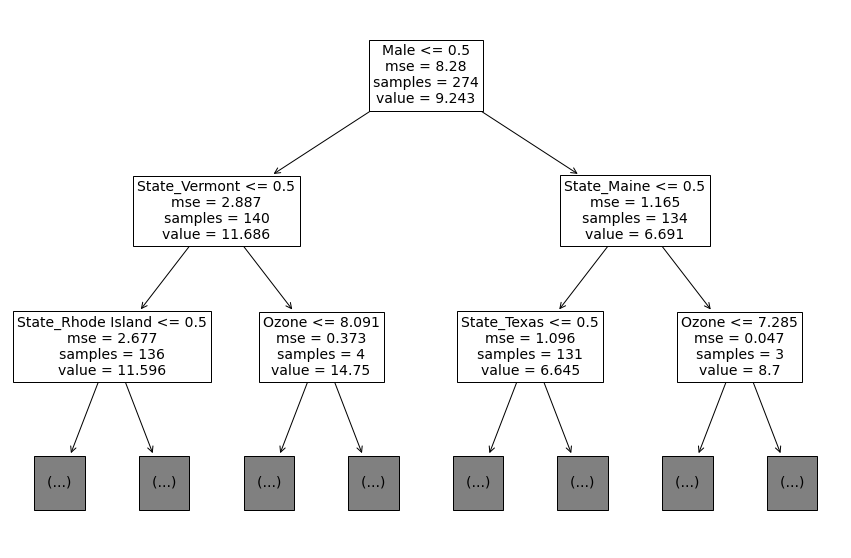

In [92]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 10))
plot_tree(tree_model2, max_depth=2, fontsize=14,feature_names=["Ozone", "PM2.5", "Female","Male", 'State_Alabama', 'State_Arizona',
       'State_Arkansas', 'State_California', 'State_Colorado',
       'State_Connecticut', 'State_Delaware', 'State_District of Columbia',
       'State_Florida', 'State_Georgia', 'State_Idaho', 'State_Illinois',
       'State_Indiana', 'State_Iowa', 'State_Kansas', 'State_Kentucky',
       'State_Louisiana', 'State_Maine', 'State_Maryland',
       'State_Massachusetts', 'State_Michigan', 'State_Minnesota',
       'State_Mississippi', 'State_Missouri', 'State_Montana',
       'State_Nebraska', 'State_Nevada', 'State_New Hampshire',
       'State_New Jersey', 'State_New Mexico', 'State_New York',
       'State_North Carolina', 'State_North Dakota', 'State_Ohio',
       'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode Island', 'State_South Carolina', 'State_South Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West Virginia',
       'State_Wisconsin', 'State_Wyoming']);

#### 2) Random Forest

In [93]:
from sklearn.ensemble import RandomForestRegressor

forest_model2 = RandomForestRegressor(max_features=1)
forest_model2.fit(X,y) 

train2["forest_pred"] = forest_model2.predict(X) 
test2["forest_pred"] = forest_model2.predict(test2[['PM25', 'Ozone', 'Female', 'Male',
       'State_Alabama', 'State_Arizona', 'State_Arkansas', 'State_California',
       'State_Colorado', 'State_Connecticut', 'State_Delaware',
       'State_District_of_Columbia', 'State_Florida', 'State_Georgia',
       'State_Idaho', 'State_Illinois', 'State_Indiana', 'State_Iowa',
       'State_Kansas', 'State_Kentucky', 'State_Louisiana', 'State_Maine',
       'State_Maryland', 'State_Massachusetts', 'State_Michigan',
       'State_Minnesota', 'State_Mississippi', 'State_Missouri',
       'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West_Virginia',
       'State_Wisconsin', 'State_Wyoming']]) 

train_rmse = np.mean((train2["forest_pred"] - train2["Prevalence"]) ** 2) ** 0.5
test_rmse = np.mean((test2["forest_pred"] - test2["Prevalence"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

Training set error for random forest: 0.4695769294809206
Test set error for random forest:     1.2029799264284629


Linear regression produce the model with the smallest test MSE, followed by Random Forest and Decision Tree. And the MSE of all three models is smaller then the previous case.

### k-nearest neighbors

In [123]:
from sklearn import neighbors
k_val= np.arange(2, 20)
knn_train_rmse2=[]
knn_test_rmse2=[]
for k in k_val:
    knn=neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(X,y)
    train2["knn_pred"] = knn.predict(X) 
    test2["knn_pred"] = knn.predict(test2[['PM25', 'Ozone', 'Female', 'Male',
       'State_Alabama', 'State_Arizona', 'State_Arkansas', 'State_California',
       'State_Colorado', 'State_Connecticut', 'State_Delaware',
       'State_District_of_Columbia', 'State_Florida', 'State_Georgia',
       'State_Idaho', 'State_Illinois', 'State_Indiana', 'State_Iowa',
       'State_Kansas', 'State_Kentucky', 'State_Louisiana', 'State_Maine',
       'State_Maryland', 'State_Massachusetts', 'State_Michigan',
       'State_Minnesota', 'State_Mississippi', 'State_Missouri',
       'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'State_Virginia', 'State_Washington', 'State_West_Virginia',
       'State_Wisconsin', 'State_Wyoming']]) 
    train_rmse = RMSE(train2["Prevalence"],train2["knn_pred"])
    test_rmse = RMSE(test2["Prevalence"],test2["knn_pred"])
    knn_train_rmse2.append(train_rmse)
    knn_test_rmse2.append(test_rmse)

Text(0, 0.5, 'RMSE')

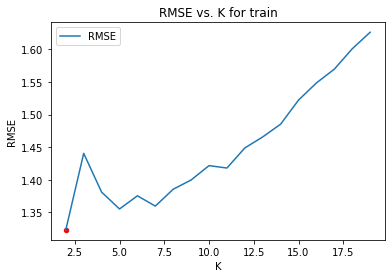

In [129]:
df=pd.DataFrame({'RMSE':knn_train_rmse2, "K":k_val})
ax = df.plot(x='K')

(df.loc[[df['RMSE'].idxmin()]]
   .plot.scatter(x='K', y='RMSE',
                 color='r', ax=ax)
)

plt.title("RMSE vs. K for train")
plt.xlabel("K")
plt.ylabel("RMSE")

Text(0, 0.5, 'RMSE')

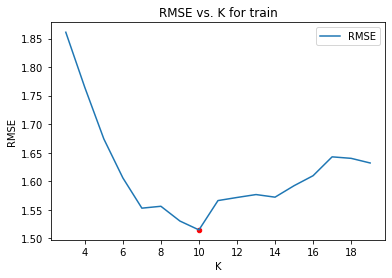

In [96]:
df=pd.DataFrame({'RMSE':knn_test_rmse2, "K":k_val})
ax = df.plot(x='K')

(df.loc[[df['RMSE'].idxmin()]]
   .plot.scatter(x='K', y='RMSE',
                 color='r', ax=ax)
)

plt.title("RMSE vs. K for train")
plt.xlabel("K")
plt.ylabel("RMSE")

In [131]:
min(knn_train_rmse2)

1.3229411769478767

In [132]:
min(knn_test_rmse2)

1.5146451729695638

## Question Here!!

### Bayesian  model

In [97]:
import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
import arviz

In [98]:
np.mean(prevalence_race_state_onehot2['Ozone'])

39.229310681160584

In [99]:
np.std(prevalence_race_state_onehot2['Ozone'])

3.03305944956011

In [100]:
np.mean(prevalence_race_state_onehot2['PM25'])

8.832176162056916

In [101]:
np.std(prevalence_race_state_onehot2['PM25'])

1.277419144694347

### Gaussian 

In [102]:
prevalence_race_state_onehot2 =  prevalence_race_state_onehot.rename(columns={'PM2.5':'PM25'})
prevalence_race_state_onehot2['Log_Prevalence'] = np.log(prevalence_race_state_onehot2['Prevalence'])

with pm.Model() as gaussian_model:
    priors = {
        "Ozone": pm.Normal.dist(mu=5, sigma=1),
        "PM25": pm.Normal.dist(mu=2, sigma=1)
    }
    pm.GLM.from_formula('Log_Prevalence ~ Ozone + PM25', data = prevalence_race_state_onehot2, 
                         family = pm.glm.families.Normal())
    # draw posterior samples
    gaussian_trace = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, PM25, Ozone, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 113 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'Ozone'}>,
        <AxesSubplot:title={'center':'Ozone'}>],
       [<AxesSubplot:title={'center':'PM25'}>,
        <AxesSubplot:title={'center':'PM25'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

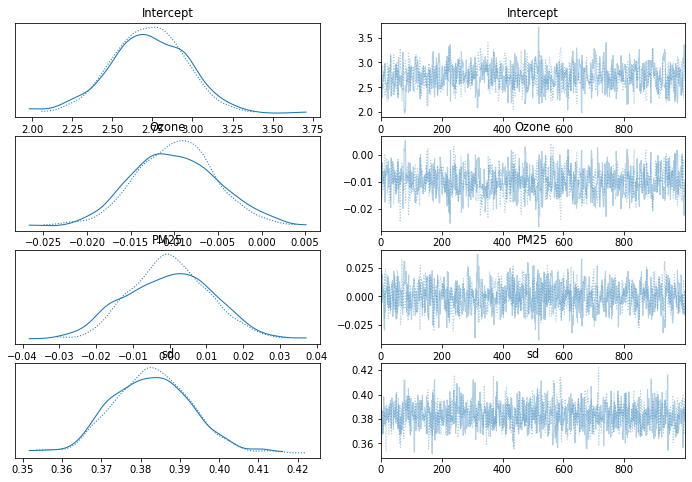

In [103]:
arviz.plot_trace(gaussian_trace)

In [104]:
gaussian_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [105]:
def show_posterior_predictive(
    trace, x=prevalence_race_state_onehot2['Ozone'], y=prevalence_race_state_onehot2['Prevalence'], num_lines=100,
    title="Posterior Predictive Distribution VS Observed Distribution for Asthma Prevalence"
):
    """
    Makes a posterior predictive plot for turbine data, 
    showing possible lines in gray
    """
    
    converter = lambda x, sample: np.exp(sample['Intercept'] + sample['Ozone'] * x)
    plt.figure(figsize=(6, 4), dpi=100)
    plt.semilogy(x, y, marker='o', linestyle='', label='Observed')
    plt.xlabel('Ozone level')
    plt.ylabel('Asthma Prevalence')
    pm.plot_posterior_predictive_glm(
        trace, samples=num_lines, eval=np.arange(25,50), 
        lm=converter, label='Predicted', alpha=0.4
    )
    plt.title(title)
    plt.legend()

/opt/conda/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning:

The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.



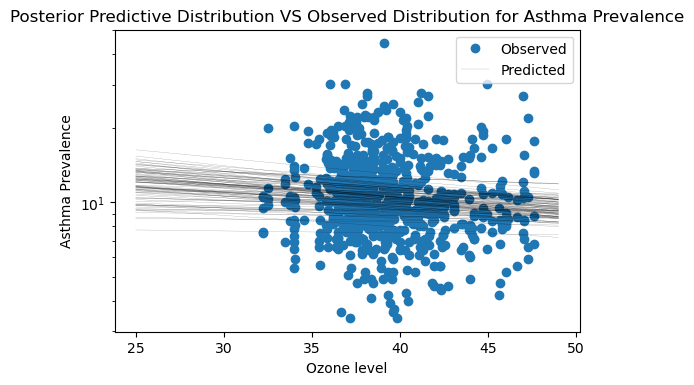

In [106]:
show_posterior_predictive(gaussian_trace)

**There is no obvious linear relationship between ozone and asthma prevalence accoring to our Baysian model.**

(array([ 17.,  23.,  88., 203., 154.,  91.,  60.,  32.,  34.,  23.]),
 array([32.23322031, 33.76960857, 35.30599683, 36.84238509, 38.37877335,
        39.91516161, 41.45154987, 42.98793813, 44.52432639, 46.06071465,
        47.59710291]),
 <BarContainer object of 10 artists>)

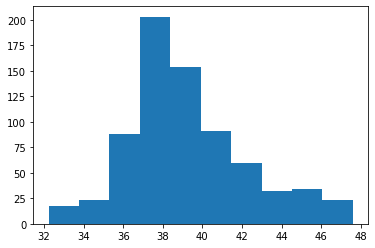

In [109]:
plt.hist(prevalence_race_state_onehot2['Ozone'])

(array([  3.,   7.,  13.,  58., 118., 138., 191., 124.,  67.,   6.]),
 array([ 4.08049792,  4.88012927,  5.67976063,  6.47939198,  7.27902334,
         8.07865469,  8.87828605,  9.67791741, 10.47754876, 11.27718012,
        12.07681147]),
 <BarContainer object of 10 artists>)

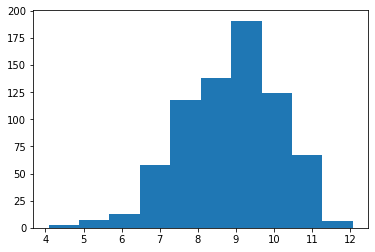

In [112]:
plt.hist(prevalence_race_state_onehot2['PM25'])

In [117]:
with pm.Model() as gaussian_model:
    priors = {
        "Ozone": pm.Normal.dist(mu=0, sigma=1),
        "PM25": pm.Normal.dist(mu=0, sigma=1)
    }
    pm.GLM.from_formula('Log_Prevalence ~ Ozone + PM25', data = prevalence_race_state_onehot2, 
                         family = pm.glm.families.Normal(), priors = priors)
    # draw posterior samples
    gaussian_trace = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, PM25, Ozone, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 126 seconds.


In [120]:
gaussian_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'Ozone'}>,
        <AxesSubplot:title={'center':'Ozone'}>],
       [<AxesSubplot:title={'center':'PM25'}>,
        <AxesSubplot:title={'center':'PM25'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

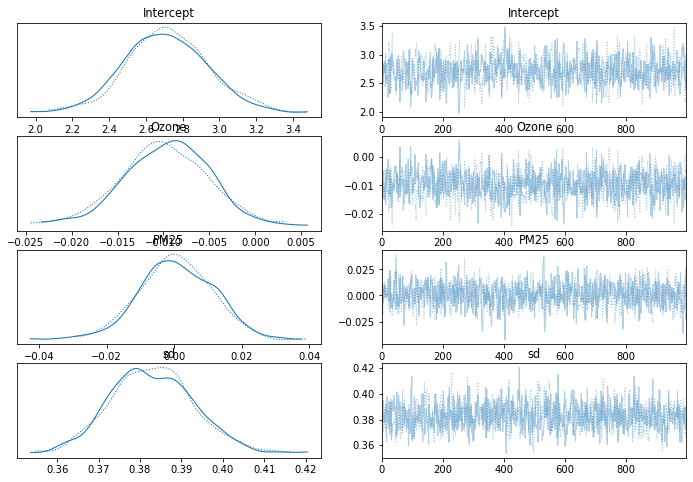

In [119]:
arviz.plot_trace(gaussian_trace)

In [151]:
print(pm.summary(gaussian_trace).round(4))

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  2.715  0.225   2.314    3.179      0.008    0.006     707.0   
Ozone     -0.010  0.005  -0.019   -0.001      0.000    0.000     797.0   
PM25       0.001  0.011  -0.019    0.022      0.000    0.000    1020.0   
sd         0.383  0.010   0.365    0.403      0.000    0.000     849.0   

           ess_tail  r_hat  
Intercept     872.0    1.0  
Ozone         827.0    1.0  
PM25         1079.0    1.0  
sd            961.0    1.0  


In [142]:
bayesian_train_predict = np.exp(2.72 - 0.01 * train1['Ozone'] + 0.001 * train1['PM25'])
bayesian_test_predict = np.exp(2.72 - 0.01 * test1['Ozone'] + 0.001 * test1['PM25'])

In [148]:
model_freq = smf.glm(formula='Log_Prevalence ~ PM25 + Ozone', data=prevalence_race_state_onehot2, 
                    family=sm.families.Gaussian())
gaussian_results_freq = model_freq.fit()
print(gaussian_results_freq.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Log_Prevalence   No. Observations:                  725
Model:                            GLM   Df Residuals:                      722
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.14612
Method:                          IRLS   Log-Likelihood:                -330.01
Date:                Thu, 09 Dec 2021   Deviance:                       105.50
Time:                        20:12:22   Pearson chi2:                     105.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7133      0.233     11.665      0.0

We tried other priors with larger mu and sigma that's similar to our original data, but they didn't work. Therefore, we decided to use standard normal distribution for both our priors.

In [160]:
prevalence_gender_state_onehot2['Log_Prevalence'] = np.log(prevalence_gender_state_onehot2['Prevalence'])
with pm.Model() as gaussian_model:
    priors = {
        "Ozone": pm.Normal.dist(mu=0, sigma=1),
        "PM25": pm.Normal.dist(mu=0, sigma=1),
        "Female": pm.Bernoulli.dist(p = 0.5)
    }
    pm.GLM.from_formula('Log_Prevalence ~ Ozone + PM25 + Female', data = prevalence_gender_state_onehot2, 
                         family = pm.glm.families.Normal(), priors = priors)
    # draw posterior samples
    gaussian_trace4 = pm.sample(1000, cores=1, return_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sd, PM25, Ozone, Intercept]
>BinaryGibbsMetropolis: [Female]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 75 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning:

invalid value encountered in double_scalars

The acceptance probability does not match the target. It is 0.891584093692736, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'Ozone'}>,
        <AxesSubplot:title={'center':'Ozone'}>],
       [<AxesSubplot:title={'center':'PM25'}>,
        <AxesSubplot:title={'center':'PM25'}>],
       [<AxesSubplot:title={'center':'Female'}>,
        <AxesSubplot:title={'center':'Female'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

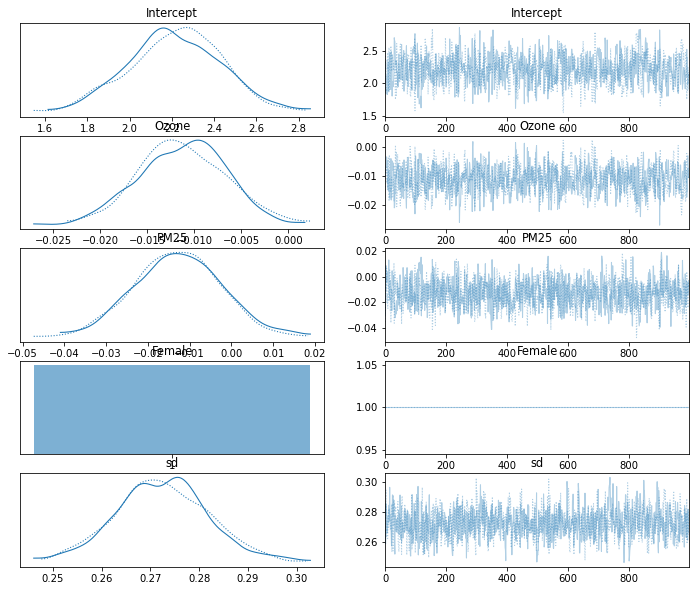

In [161]:
arviz.plot_trace(gaussian_trace4)

In [162]:
print(pm.summary(gaussian_trace4).round(4))

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  2.217  0.219   1.798    2.601      0.008    0.006     786.0   
Ozone     -0.011  0.005  -0.020   -0.003      0.000    0.000     799.0   
PM25      -0.013  0.010  -0.033    0.006      0.000    0.000    1142.0   
Female     1.000  0.000   1.000    1.000      0.000    0.000    2000.0   
sd         0.272  0.009   0.252    0.289      0.000    0.000    1033.0   

           ess_tail  r_hat  
Intercept     734.0   1.00  
Ozone         919.0   1.01  
PM25          960.0   1.00  
Female       2000.0    NaN  
sd            948.0   1.00  


/opt/conda/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning:

invalid value encountered in double_scalars



### Results

### Discussion